## Constructing grids for COAWST / SWAN for Cape Cod Bay and Sandwich

`CCBay_grid_v2`

This is a duplicate of the code in `_v1` but uses bathymetry from January 25, 2017 and names the grids FG2, MG2, and CG2.

#### Data
* 10-gridded topo/bathy for entire CCBay from Brian Andrews synthesis
* 5-m gridded 2013 topo/bathy from USACE lidar in from Plymouth to Sandy Neck
* 0.1-m gridded UAS structure-from-motion topography for Sandwich Town Neck Beach
`2017-01-25_SandwichTNB_DEM_10cm_trimmed_channel_mask.tif`
* Crappy coastline for visual reference based on 0-m contour extracted from 10-m grid

#### Grids
Three grids (fine, medium, and coarse) are developed in this notebook: FG1, MG1, and CG1. The data and original grid coordinates are all in NAD83(2011) UTM Zone 19N (meters) and NADV88 (m). The lat/lon coordinates exported for COAWST are in WGS84.

#### Process
* Define some of the functions used later.
* Load the shoreline data.
* Make the grid coordinates, based on origin, rotation, and spacing. This produces meshes Xf,Yf; Xm,Ym; and Xc, Yc.
* Import the topo/bathy data as arrays from `.tif` tiles.
* Smooth and fill gaps in 10-m data.
* Smooth lidar data and remove outer 4 cells.
* Smooth and decimate the SfM data.
* Make fine grid
    * Interpolate SfM data onto fine grid
    * Interpolate lidar data onto fine grid
    * Cut hole in lidar version of fine grid where SfM data exists
    * Build complete fine grid by combining SfM and lidar versions
    * Apply a linear blend across the junction of the two data sets, extending 5 cells each way
* Make medium grid
    * Interpolate fine grid data onto medium grid
    * Interpolate lidar data onto medium grid
    * Interpolate 10-m data onto medium grid
    * Cut hole in 10-m version of medium grid where lidar data exists
    * Cut hole in lidar version of medium grid where fine grid data exists
    * Build complete grid by combining fine, lidar, and 10-m versions of medium grid
* Make coarse grid
    * Interpolate medium grid data onto coarse grid
    * Interpolate 10-m data onto coarse grid
    * Cut hole in 10-m version of coarse grid where medium grid data exists
    * Build complete grid by combining medium and 10-m versions of coarse grid
* Calculate the lat/lon coordinates for the grids.
* Export the grids as `.mat` files.

    

In [1]:
import numpy as np
import pandas as pd
import scipy.io

from IPython.display import display, HTML
import matplotlib.pyplot as plt
from scipy import interpolate
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
from scipy.signal import convolve as scipy_convolve

import xarray as xr
%matplotlib inline

In [2]:
# some functions used here
def pcoord(x, y):
    """
    Convert x, y to polar coordinates r, az (geographic convention)
    r,az = pcoord(x, y)
    """
    r  = np.sqrt( x**2 + y**2 )
    az = np.degrees( np.arctan2(x, y) )
    # az[where(az<0.)[0]] += 360.
    az = (az+360.)%360.
    return r, az

def xycoord(r, az):
    """
    Convert r, az [degrees, geographic convention] to rectangular coordinates
    x,y = xycoord(r, az)
    """
    x = r * np.sin(np.radians(az))
    y = r * np.cos(np.radians(az))
    return x, y

def buildGrid(xp,yp,alp,dx,dy,mxc,myc):
    '''
    X, Y = buildGrid(xp,yp,alp,dx,dy,mxc,myc) builds a rectangular grid
    
    Input :
        xp: x grid origin
        yp: y grid origin
        alp: degrees rotation of x-axis
        dx: x-direction grid spacing
        dy: y-direction grid spacing
        mxc: number of meshes in x-direction
        myc: number of meshes in y-direction
        
    Based on the Matlab function of Dave Thompson
    '''
    xlen = (mxc-1)*dx
    ylen = (myc-1)*dy
    
    x = np.arange(xp,xp+xlen+dx,dx)
    y = np.arange(yp,yp+ylen+dy,dy)

    X,Y = np.meshgrid(x,y);
    X = X-xp
    Y = Y-yp

    if alp != 0.:
       r,az = pcoord(X,Y)
       X,Y = xycoord(r,az+alp)
        
    X = X+xp
    Y = Y+yp
    print("Shape of X and Y: ",np.shape(X),np.shape(Y))

    return X, Y

In [3]:
# data directory
ddir = r"D:/crs/proj/2015_Sandwich/CCBay_Modeling/"

In [4]:
# load the coarse shoreline
s = np.genfromtxt(ddir+'shoreline.txt', delimiter=',')

In [5]:
# spacing for the three grids
dxyf = 5.
dxym = 35.
dxyc = 245.
# angle of north end
alp = 130.

# make the coarse box
# direction to origin of coarse grid...same angle for base line, even
# increment of dxc
# back calculate location of lower left corner from upper left corner
LMc = 192.
MMc = 68.
xul = 366490.
yul = 4652500.
dxo,dyo = xycoord( (MMc-1)*dxyc, alp+90)
xpc = xul+dxo
ypc = yul+dyo

xlenc = (LMc-1)*dxyc
ylenc = (MMc-1)*dxyc

# box corners
bc = np.empty((4,2),float)
bc[0,:]=[xpc,ypc]
dxb, dyb = xycoord( xlenc, alp );
bc[1,:] = bc[0,:]+[dxb, dyb];
dxb, dyb = xycoord( ylenc, alp-90);
bc[2,:] = bc[1,:]+[dxb, dyb];
dxb, dyb = xycoord( xlenc, alp+180);
bc[3,:] = bc[2,:]+[dxb, dyb]

# make the coarse grid
dxc = dxyc;
dyc = dxyc;
print('Coarse grid is {} x {}, total = {}'.format(LMc,MMc,LMc*MMc))
Xc,Yc = buildGrid( 0., 0., alp-90., dxc, dyc, LMc, MMc );
Xc = Xc + xpc
Yc = Yc + ypc

# box corners should be the same as the corner points in X and Y
print(bc)

print(Xc[0,0],Yc[0,0])
print(Xc[-1,0],Yc[-1,0])

Coarse grid is 192.0 x 68.0, total = 13056.0
Shape of X and Y:  (68, 192) (68, 192)
[[  355938.641387    4639925.3804662 ]
 [  391785.69110275  4609846.13427092]
 [  402337.04971575  4622420.75380472]
 [  366490.          4652500.        ]]
355938.641387 4639925.38047
366490.0 4652500.0


In [6]:
# medium grid box
dxm = dxym
dym = dxym
LMm = 190
MMm = 64
# check to make sure it is divisible by dxc and dyc
print("These numbers should be integers:")
print((LMm-1)*dxm/dxc)
print((MMm-1)*dym/dyc)
# indices in coarse grid for origin of medium grid (found by hand)
row = 7
col = 88
# corresponding coordinates
xpm = Xc[row,col];
ypm = Yc[row,col];
print("Origin of medium grid")
print(xpm,ypm)
print('Medium grid is {} x {}, total = {}'.format(LMm,MMm,LMm*MMm))
Xm,Ym = buildGrid( 0., 0., alp-90., dxm, dym, LMm, MMm );
Xm = Xm + xpm
Ym = Ym + ypm
xlenm = (LMm-1)*dxm; # should be even increment of coarse grid dxc
ylenm = (MMm-1)*dym; # should be even increment of coarse grid dyc

These numbers should be integers:
27.0
9.0
Origin of medium grid
373556.940331 4627380.64582
Medium grid is 190 x 64, total = 12160
Shape of X and Y:  (64, 190) (64, 190)


(4627000.0, 4628000.0)

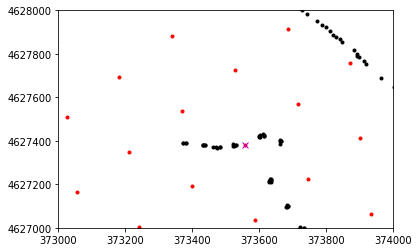

In [7]:
# plot to check that origin == correct coarse grid location
plt.plot(s[:,0],s[:,1],'.k')
plt.plot(Xc,Yc,'.r');
plt.plot(xpm,ypm,'xm');
plt.xlim((3.73e5,3.74e5))
plt.ylim((4.627e6,4.628e6))

In [8]:
# medium grid box
dxf = dxyf
dyf = dxyf
LMf = 288
MMf = 126
# check to make sure it is divisible by dxc and dyc
print("These numbers should be integers:")
print((LMf-1)*dxf/dxm)
print((MMf-1)*dyf/dym)
# indices in coarse grid for origin of medium grid (found by hand)
row = 3
col = 95
# corresponding coordinates
xpf = Xm[row,col];
ypf = Ym[row,col];
print("Origin of fine grid")
print(xpf,ypf)
print('Fine grid is {} x {}, total = {}'.format(LMf,MMf,LMf*MMf))
Xf,Yf = buildGrid( 0., 0., alp-90., dxf, dyf, LMf, MMf );
Xf = Xf + xpf
Yf = Yf + ypf

These numbers should be integers:
41.0
17.857142857142858
Origin of fine grid
376171.530804 4625323.81169
Fine grid is 288 x 126, total = 36288
Shape of X and Y:  (126, 288) (126, 288)


(4624000.0, 4626000.0)

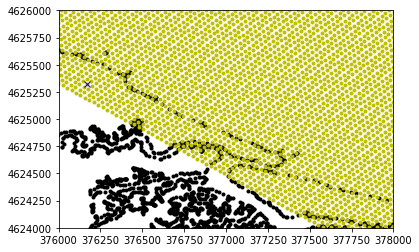

In [9]:
# plot to check that origin == correct coarse grid location
plt.plot(s[:,0],s[:,1],'.k')
plt.plot(Xm,Ym,'.y');
plt.plot(xpf,ypf,'xb');
plt.xlim((3.760e5,3.78e5))
plt.ylim((4.624e6,4.626e6))

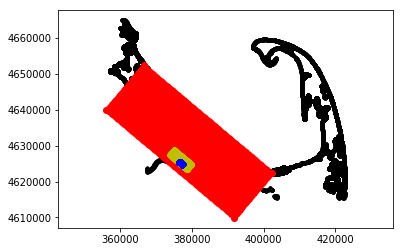

In [10]:
plt.plot(s[:,0],s[:,1],'.k')
plt.plot(bc[:,0],bc[:,1],'or')
plt.plot(bc[:,0],bc[:,1],'-r')
plt.plot([bc[0,0], bc[3,0]],[bc[0,1], bc[3,1]],'-r')
plt.plot(Xc,Yc,'.r')
plt.plot(Xm,Ym,'.y')
plt.plot(Xf,Yf,'.b')
plt.axis('equal');

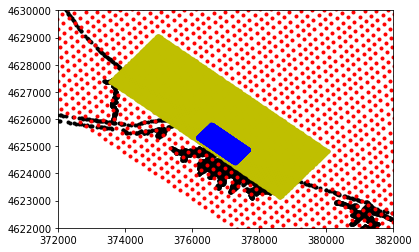

In [11]:
plt.plot(s[:,0],s[:,1],'.k')
plt.plot(Xc,Yc,'.r')
plt.plot(Xm,Ym,'.y')
plt.plot(Xf,Yf,'.b')
plt.xlim((3.72e5,3.82e5))
plt.ylim((4.622e6,4.63e6));

(4624000.0, 4626000.0)

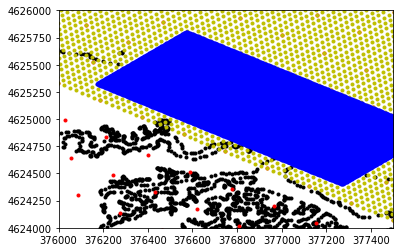

In [12]:
plt.plot(s[:,0],s[:,1],'.k')
plt.plot(Xc,Yc,'.r')
plt.plot(Xm,Ym,'.y')
plt.plot(Xf,Yf,'.b')
plt.xlim((3.76e5,3.775e5))
plt.ylim((4.624e6,4.626e6))

#### Import the bathymetry data in gridded `.tif` files

In [13]:
%%time
# Instead of importing as points, import from the tiffs, which allows grid smoothing
'''
# These were exported from Global Mapper from the grids as xyz files
p10 = np.genfromtxt(ddir+'CCBay10m_south_points.txt', delimiter=',')
plidar = np.genfromtxt(ddir+'2013_lidar_points.txt', delimiter=',')
psfm = np.genfromtxt(ddir+'2016-03-30_SandwichTNB_points.txt', delimiter=',')
'''
# This grid was generated by Brian Andrews in ArcGIS
# open the tif with XArray as a DataArray
fn = ddir+'CCBay_10m.tif'
da = xr.open_rasterio(fn)

# Not sure how da.values got a singleton dimension, but squeeze gets rid of it.
print( np.shape(np.flipud(da['y'].values)), np.shape(da['x'].values), np.shape( np.flipud(da.values)) )

# However, make sure to squeeze before flipping
z10 = np.flipud(np.squeeze(da.values))

# Missing values are -3.40282347e+38. Replace with NaNs as follows:
z10[z10 <= -3.4e+38]=np.NaN

x10 = da['x'].values
y10 = np.flipud(da['y'].values)

(4952,) (8215,) (1, 4952, 8215)
Wall time: 2.61 s


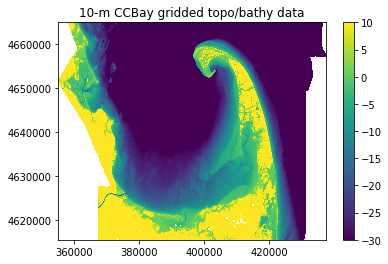

In [14]:
plt.pcolormesh(x10,y10,z10,vmin=-30,vmax=10)
plt.title('10-m CCBay gridded topo/bathy data')
plt.colorbar();

(4952, 8215)
(3852, 4874) (4874,) (3852,)


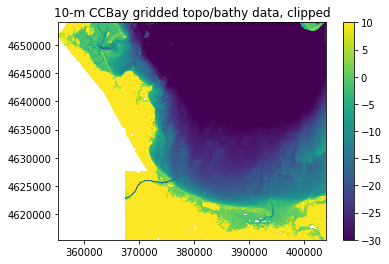

In [15]:
# clip out data we dont need to make interpolations go faster
ix = int(np.argwhere(x10<=404000.)[-1])
iy = int(np.argwhere(y10<=4654000.)[-1])
print(np.shape(z10))
z10c = z10[0:iy,0:ix]
x10c=x10[:ix]
y10c=y10[:iy]
print(np.shape(z10c),np.shape(x10c),np.shape(y10c))
plt.pcolormesh(x10c,y10c,z10c,vmin=-30,vmax=10)
plt.title('10-m CCBay gridded topo/bathy data, clipped')
plt.colorbar();

### Get rid of the NaNs in the 10-m data
* Smooth with Astropy Gaussian convolution, which replaces NaNs w/ interpolated values
* Make a second grid by smoothing again
* Fill NaNs in the first grid with values from the twice-smoothed grid. This fills some holes in Barnstble Harbor
* Fill remainder of NaNs with fixed value

In [16]:
%%time
# Smooth with gaussian 
kernel = Gaussian2DKernel(x_stddev=2)
# Astropy's convolution replaces the NaN pixels with a kernel-weighted
# interpolation from their neighbors. The 'extend' option prevents issues at edges with NaNs.
z10cs = convolve(z10c, kernel, boundary='extend')

# There are still some NaNs in this...smooth again, but only use these data to fill NaNs
z10css = convolve(z10cs, kernel, boundary='extend')

Wall time: 56.1 s


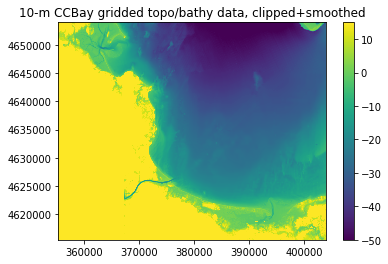

In [17]:
# Replace some of the NaNs with values from the twice-smoothed array.
# This fills in the holes in Barnstable Harbor with semi-reasonable depths.
z10csf = z10cs.copy()
z10csf[np.isnan(z10cs)]=z10css[np.isnan(z10cs)]
# Now set remaining NaNs to a fixed value
z10csf[np.isnan(z10csf)]=20.

plt.pcolormesh(x10c,y10c,z10csf,vmin=-50,vmax=15)
plt.title('10-m CCBay gridded topo/bathy data, clipped+smoothed')
plt.colorbar();

### Import the lidar data and smooth

In [18]:
# This grid was generated by CRS GlobalMapper from USACE lidar data
# open the tif with XArray as a DataArray
fn = ddir+'5-m_grid_from_lidar.tif'
da = xr.open_rasterio(fn)

# Not sure how da.values got a singleton dimension, but squeeze gets rid of it.
print( np.shape(np.flipud(da['y'].values)), np.shape(da['x'].values), np.shape( np.flipud(da.values)) )

# However, make sure to squeeze before flipping
zlidar = np.flipud(np.squeeze(da.values))

# Missing values are -32767. Can replace with NaNs as follows:
zlidar[zlidar<-32766]=np.NaN
xlidar = da['x'].values
ylidar = np.flipud(da['y'].values)

(1673,) (2450,) (1, 1673, 2450)


In [19]:
# Smooth the lidar data with the scipy convolution. This will remove data around the edges.
kernel = Gaussian2DKernel(x_stddev=.5)
print("kernel size: ", kernel.shape)
# Convolution: scipy's direct convolution mode spreads out NaNs
zlidars = scipy_convolve(zlidar, kernel, mode='same', method='direct')

kernel size:  (5, 5)


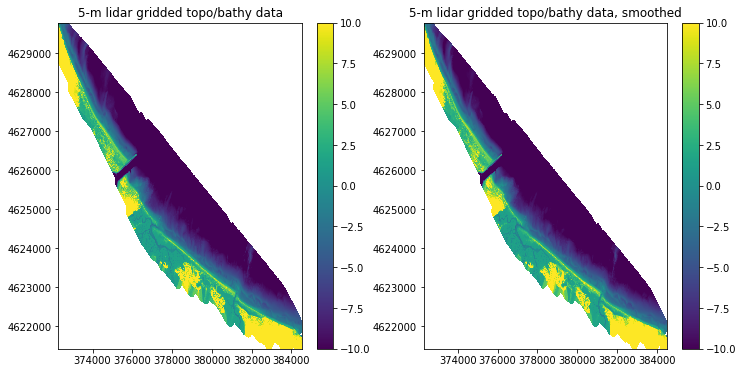

In [20]:
fig = plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.pcolormesh(xlidar,ylidar,zlidar,vmin=-10,vmax=10)
plt.title('5-m lidar gridded topo/bathy data')
plt.colorbar();
plt.subplot(1,2,2)
plt.pcolormesh(xlidar,ylidar,zlidars,vmin=-10,vmax=10)
plt.title('5-m lidar gridded topo/bathy data, smoothed')
plt.colorbar();

### Import the SfM data

(10175,) (11191,) (1, 10175, 11191)


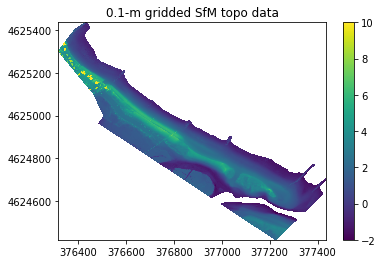

In [21]:
# This grid was generated by CRS in Photoscan
# open the tif with XArray as a DataArray
fn = ddir+'2017-01-25_SandwichTNB_DEM_10cm_trimmed_channel_mask.tif'
#fn = ddir+'2016-03-30_SandwichTNB_AS_DEM_10cm_trimmed.tif'
da = xr.open_rasterio(fn)

# Not sure how da.values got a singleton dimension, but squeeze gets rid of it.
print( np.shape(np.flipud(da['y'].values)), np.shape(da['x'].values), np.shape( np.flipud(da.values)) )

# However, make sure to squeeze before flipping
zsfm = np.flipud(np.squeeze(da.values))

# Missing values are -32767. Can replace with NaNs as follows:
zsfm[zsfm<-32766]=np.NaN

xsfm = da['x'].values
ysfm = np.flipud(da['y'].values)

plt.pcolormesh(xsfm,ysfm,zsfm,vmin=-2,vmax=10)
plt.title('0.1-m gridded SfM topo data')
plt.colorbar();

### Smooth the SfM data
Use the Astropy library because it will replace NaNs with values interpolated by the smoothing kernel.

http://docs.astropy.org/en/stable/index.html

In [22]:
# We smooth with a Gaussian kernel with x_stddev=1 (and y_stddev=1)
# It is a 9x9 array
kernel = Gaussian2DKernel(x_stddev=1)
# astropy's convolution replaces the NaN pixels with a kernel-weighted
# interpolation from their neighbors
zsfm_s = convolve(zsfm, kernel)

### Decimate the SfM data from 10 cm to 50 cm: -> `zsfm_sd`

(10175, 11191) (2035, 2239) (2239,) (2035,)


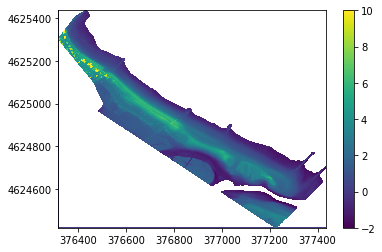

In [23]:
# Decimate the sfm data
zsfm_sd = zsfm_s[::5,::5]
xsfm_d = xsfm[::5]
ysfm_d = ysfm[::5]
print(np.shape(zsfm_s),np.shape(zsfm_sd),np.shape(xsfm_d),np.shape(ysfm_d))
plt.pcolormesh(xsfm_d,ysfm_d,zsfm_sd,vmin=-2,vmax=10)
plt.colorbar();

### Interpolate the SfM data onto the fine grid: ->`Zf1`...with lots of NaNs.

In [24]:
%%time
# Make the fine grid with the SfM data
xp, yp = np.meshgrid(xsfm_d,ysfm_d)
xpyp = np.array((np.ravel(xp),np.ravel(yp))).T
zp = np.ravel(zsfm_sd)
print('xp ',np.shape(xp),'yp: ' ,np.shape(yp),'xpyp: ',np.shape(xpyp),'zp: :',np.shape(zp))
print('Xf ',np.shape(Xf),'Yf: ' ,np.shape(Yf),'grid points: ',np.shape(np.array((np.ravel(Xf), np.ravel(Yf))).T))

# interpolate data on to fine grid
Zf1 = interpolate.griddata( xpyp, zp, np.array((np.ravel(Xf), np.ravel(Yf))).T, method='linear', fill_value=np.NaN, rescale=False)
Zf1 = np.reshape(Zf1,np.shape(Xf))

xp  (2035, 2239) yp:  (2035, 2239) xpyp:  (4556365, 2) zp: : (4556365,)
Xf  (126, 288) Yf:  (126, 288) grid points:  (36288, 2)
Wall time: 15.7 s


Text(0.5,1,'Profiles')

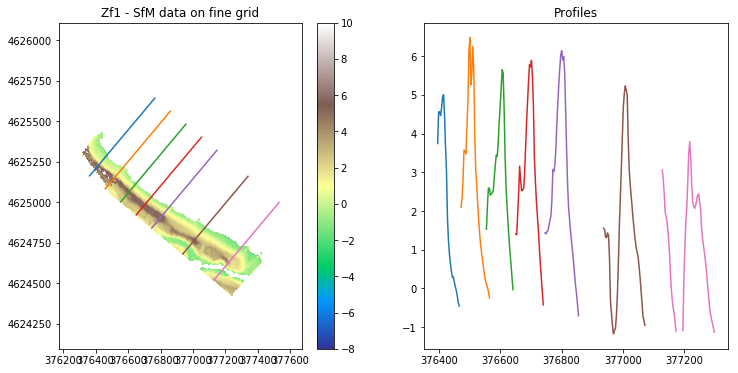

In [25]:
fig = plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.pcolormesh(Xf,Yf,Zf1,vmin=-8,vmax=10,cmap=plt.cm.terrain)
for i in np.array([50,75,100,125,150,200,250]):
    plt.plot(Xf[:,i],Yf[:,i],'-')
plt.title('Zf1 - SfM data on fine grid')
plt.colorbar()
plt.axis('equal');
plt.subplot(1,2,2)
for i in np.array([50,75,100,125,150,200,250]):
    plt.plot(Xf[:,i],Zf1[:,i],'-')
plt.title('Profiles')

### Interpolate the smoothed lidar data onto the fine grid: -> `Zf2`...no holes.

In [26]:
%%time
# Make the fine grid with lidar data
xp, yp = np.meshgrid(xlidar,ylidar)
xpyp = np.array((np.ravel(xp),np.ravel(yp))).T
zp = np.ravel(zlidars)
print('xp ',np.shape(xp),'yp: ' ,np.shape(yp),'xpyp: ',np.shape(xpyp),'zp: :',np.shape(zp))
print('Xf ',np.shape(Xf),'Yf: ' ,np.shape(Yf),'grid points: ',np.shape(np.array((np.ravel(Xf), np.ravel(Yf))).T))

# interpolate data on to fine grid
Zf2 = interpolate.griddata( xpyp, zp, np.array((np.ravel(Xf), np.ravel(Yf))).T, method='linear', fill_value=np.NaN, rescale=False)
Zf2 = np.reshape(Zf2,np.shape(Xf))

xp  (1673, 2450) yp:  (1673, 2450) xpyp:  (4098850, 2) zp: : (4098850,)
Xf  (126, 288) Yf:  (126, 288) grid points:  (36288, 2)
Wall time: 1min 27s


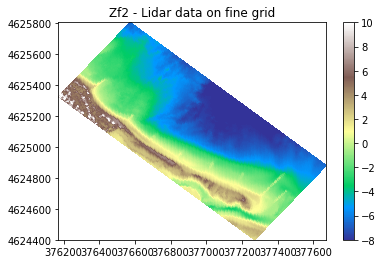

In [27]:
plt.pcolormesh(Xf,Yf,Zf2,vmin=-8,vmax=10,cmap=plt.cm.terrain)
plt.title('Zf2 - Lidar data on fine grid')
plt.colorbar();

### Mask out the regions in `Zf2` where `Zf1` has data: -> `Zf3`...has gaps.

In [28]:
Zf_has_sfm = np.array(~np.isnan(Zf1))
Zf_has_lidar = ~Zf_has_sfm
#Zf3 = np.ones_like(Zf2)*np.NaN
Zf3 = Zf2.copy()
Zf3[Zf_has_sfm]=np.NaN

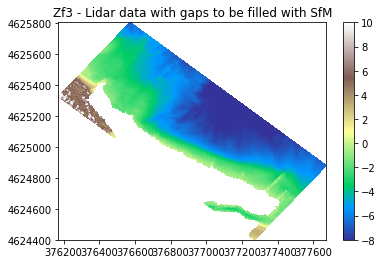

In [29]:
plt.pcolormesh(Xf,Yf,Zf3,vmin=-8,vmax=10,cmap=plt.cm.terrain)
plt.title('Zf3 - Lidar data with gaps to be filled with SfM')
plt.colorbar();

### Make a complete grid by `nansum`ing the two grids:-> `Zf4`

This grid is complete, but there can be a sharp discontinuity between the two datasets. See next step for smoothing.

Text(0.5,1,'Profiles with notches near -1 m')

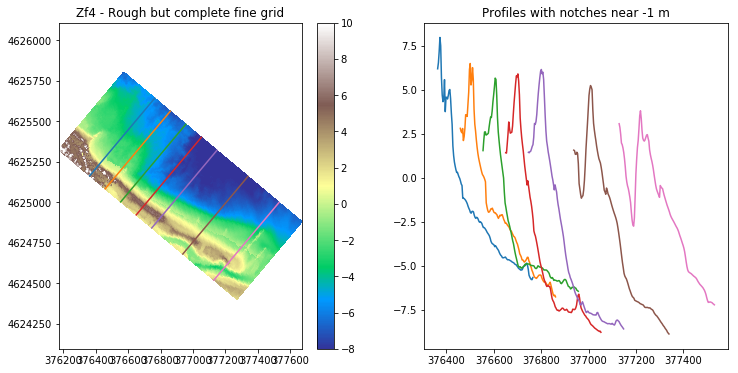

In [30]:
Zstack = np.stack((Zf1,Zf3))
Zf4 = np.nanmean(Zstack, 0)

fig = plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.pcolormesh(Xf,Yf,Zf4,vmin=-8,vmax=10,cmap=plt.cm.terrain)
for i in np.array([50,75,100,125,150,200,250]):
    plt.plot(Xf[:,i],Yf[:,i],'-')
plt.title('Zf4 - Rough but complete fine grid')
plt.colorbar()
plt.axis('equal');
plt.subplot(1,2,2)
for i in np.array([50,75,100,125,150,200,250]):
    plt.plot(Xf[:,i],Zf4[:,i],'-')
plt.title('Profiles with notches near -1 m')

### Make a set of indices where the grids merge
The edge is defined as last NaN value in the lidar grid. If the whole transect is missing, the index is set at -1.

In [31]:
idx=[]
npoints, ntransects= np.shape(Zf3)
print('ntransects, npoints: ',ntransects,npoints)
for i in range(ntransects):
    j=np.argwhere(np.isnan(Zf3[:,i]))
    if(j.any()):
        idx = np.append(idx,j[-1])
    else:
        idx = np.append(idx,-1)

ntransects, npoints:  288 126


### Apply a linear tapered weighting function across the boundary: -> `Zf`

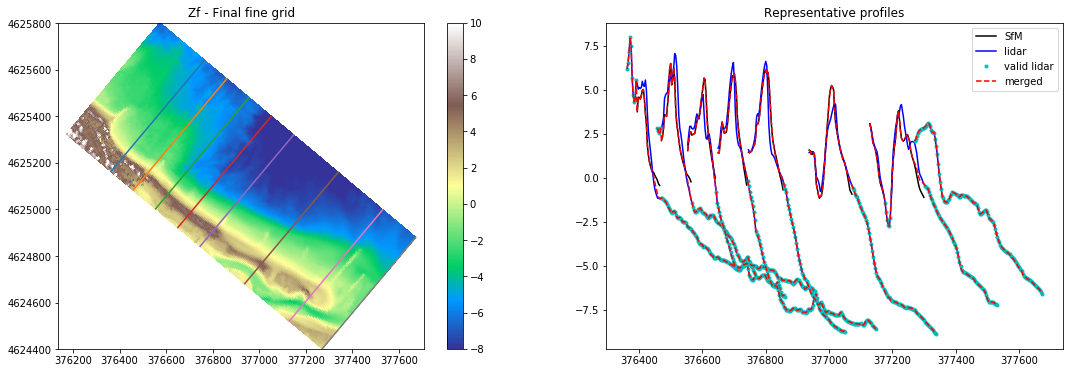

In [32]:
noff = 5
ioff = np.arange(-noff,noff+1,1)
wght= (1.-(ioff+noff)/(2.*noff))
Zf = np.ones_like(Zf1)*np.NaN

for i in range(ntransects):
    # default to lidar data
    Zf[:,i]=Zf4[:,i]
    
    if idx[i]>noff:
        # idx[i] is border of SfM data; k is index where weights start to taper
        k = int(idx[i])-noff
        # array of SfM weights
        swght = np.zeros_like(Zf3[:,i])
        # select for SfM inside k-noff
        swght[0:k-noff] = 1.
        # select for lidar where SfM is missing inside k-noff
        idx_nosfm = np.argwhere(np.isnan(Zf1[0:k-noff,i]))
        swght[idx_nosfm]= 0.
        # taper from SfM to lidar
        swght[k-noff:int(k+1+noff)]=wght
        # lidar weights are 1-SfM weights
        lwght=1.-swght
        # sum weighted profiles
        Zstack= np.stack(  (Zf1[:,i]*swght,\
                            Zf2[:,i]*lwght) )
        Zmerge = np.nansum(Zstack,0)
        Zf[:,i]=Zmerge

# plot
fig = plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.pcolormesh(Xf,Yf,Zf,vmin=-8,vmax=10,cmap=plt.cm.terrain)
for i in np.array([50,75,100,125,150,200,250,287]):
    plt.plot(Xf[:,i],Yf[:,i],'-')

plt.title('Zf - Final fine grid')
plt.colorbar()
plt.axis('equal');
plt.subplot(1,2,2)
for i in np.array([50,75,100,125,150,200,250]):
    plt.plot(Xf[:,i],Zf1[:,i],'-k')
    plt.plot(Xf[:,i],Zf2[:,i],'-b')
    plt.plot(Xf[:,i],Zf3[:,i],'.c')
    plt.plot(Xf[:,i],Zf[:,i],'--r')

# one last transect to get the legend
i=287
plt.plot(Xf[:,i],Zf1[:,i],'-k',label='SfM')
plt.plot(Xf[:,i],Zf2[:,i],'-b',label='lidar')
plt.plot(Xf[:,i],Zf3[:,i],'.c',label='valid lidar')
plt.plot(Xf[:,i],Zf[:,i],'--r',label='merged')
plt.title('Representative profiles')
plt.legend();

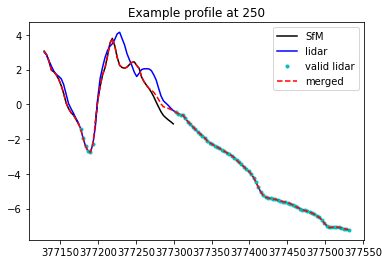

In [33]:
i = 250
plt.plot(Xf[:,i],Zf1[:,i],'-k',label='SfM')
plt.plot(Xf[:,i],Zf2[:,i],'-b',label='lidar')
plt.plot(Xf[:,i],Zf3[:,i],'.c',label='valid lidar')
plt.plot(Xf[:,i],Zf[:,i],'--r',label='merged')
#plt.xlim(idx[i]-20,idx[i]+20)
plt.title('Example profile at '+str(i))
plt.legend();

### Interpolate fine grid onto the medium grid: -> `Zm1` with lots of missing data

xp  (1673, 2450) yp:  (1673, 2450) xpyp:  (36288, 2) zp: : (36288,)
Xm  (64, 190) Ym:  (64, 190) grid points:  (12160, 2)
Wall time: 649 ms


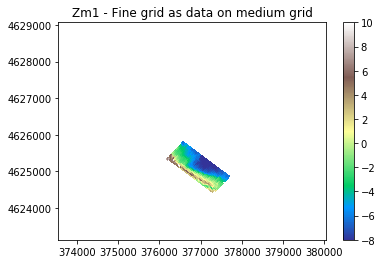

In [34]:
%%time
xpyp = np.array((np.ravel(Xf),np.ravel(Yf))).T
zp = np.ravel(Zf)
print('xp ',np.shape(xp),'yp: ' ,np.shape(yp),'xpyp: ',np.shape(xpyp),'zp: :',np.shape(zp))
print('Xm ',np.shape(Xm),'Ym: ' ,np.shape(Ym),'grid points: ',np.shape(np.array((np.ravel(Xm), np.ravel(Ym))).T))

# interpolate data on to fine grid
Zm1 = interpolate.griddata( xpyp, zp, np.array((np.ravel(Xm), np.ravel(Ym))).T, method='linear', fill_value=np.NaN, rescale=False)
Zm1 = np.reshape(Zm1,np.shape(Xm))

plt.pcolormesh(Xm,Ym,Zm1,vmin=-8,vmax=10,cmap=plt.cm.terrain)
plt.title('Zm1 - Fine grid as data on medium grid')
plt.colorbar();

### Interpolate the lidar data on to the medium grid: -> `Zm2` with a little missing data at outer edge

xp  (1673, 2450) yp:  (1673, 2450) xpyp:  (4098850, 2) zp: : (4098850,)
Xm  (64, 190) Ym:  (64, 190) grid points:  (12160, 2)
Wall time: 1min 24s


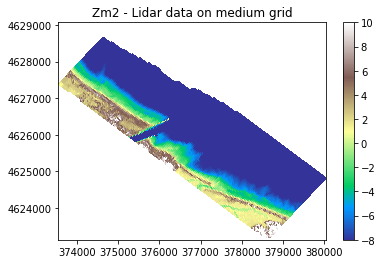

In [35]:
%%time
xp, yp = np.meshgrid(xlidar,ylidar)
xpyp = np.array((np.ravel(xp),np.ravel(yp))).T
zp = np.ravel(zlidars)
print('xp ',np.shape(xp),'yp: ' ,np.shape(yp),'xpyp: ',np.shape(xpyp),'zp: :',np.shape(zp))
print('Xm ',np.shape(Xm),'Ym: ' ,np.shape(Ym),'grid points: ',np.shape(np.array((np.ravel(Xm), np.ravel(Ym))).T))

# interpolate data on to medium grid
Zm2 = interpolate.griddata( xpyp, zp, np.array((np.ravel(Xm), np.ravel(Ym))).T, method='linear', fill_value=np.NaN, rescale=False)
Zm2 = np.reshape(Zm2,np.shape(Xm))

plt.pcolormesh(Xm,Ym,Zm2,vmin=-8,vmax=10,cmap=plt.cm.terrain)
plt.title('Zm2 - Lidar data on medium grid')
plt.colorbar();

### Remove 4 cells from outer edge of the lidar data. Weird stuff happens there.

ntransects, npoints:  190 64


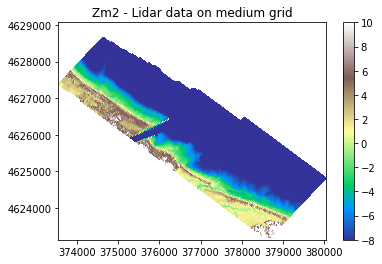

In [36]:
# Find the indices for the end of each transect
idx=[]
npoints, ntransects= np.shape(Zm2)
print('ntransects, npoints: ',ntransects,npoints)
for i in range(ntransects):
    j=np.argwhere(np.isnan(Zm2[:,i]))
    if(j.any()):
        idx = np.append(idx,j[-1])
    else:
        idx = np.append(idx,-1)

# NaN from edge minus noff to end
noff = 4 #  grid cells = 70 m
for i in range(ntransects):
    if idx[i]>noff:
        k = int(idx[i])-noff
        Zm2[k:,i]=np.NaN

plt.pcolormesh(Xm,Ym,Zm2,vmin=-8,vmax=10,cmap=plt.cm.terrain)
plt.title('Zm2 - Lidar data on medium grid')
plt.colorbar();

### Interpolate the clipped, smoothed, filled 10-m data on to the medium grid: -> `Zm3` with full coverage

In [37]:
%%time
xp, yp = np.meshgrid(x10c,y10c)
xpyp = np.array((np.ravel(xp),np.ravel(yp))).T
zp = np.ravel(z10csf)
print('xp ',np.shape(xp),'yp: ' ,np.shape(yp),'xpyp: ',np.shape(xpyp),'zp: :',np.shape(zp))
print('Xm ',np.shape(Xm),'Ym: ' ,np.shape(Ym),'grid points: ',np.shape(np.array((np.ravel(Xm), np.ravel(Ym))).T))
Zm3 = interpolate.griddata( xpyp, zp, np.array((np.ravel(Xm), np.ravel(Ym))).T, method='nearest', fill_value=np.NaN, rescale=False)
Zm3 = np.reshape(Zm3,np.shape(Xm))

xp  (3852, 4874) yp:  (3852, 4874) xpyp:  (18774648, 2) zp: : (18774648,)
Xm  (64, 190) Ym:  (64, 190) grid points:  (12160, 2)
Wall time: 3min 2s


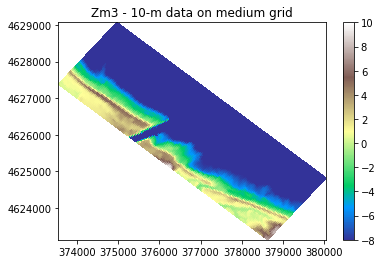

In [38]:
plt.pcolormesh(Xm,Ym,Zm3,vmin=-8,vmax=10,cmap=plt.cm.terrain)
plt.title('Zm3 - 10-m data on medium grid')
plt.colorbar();

### Remove lidar coverage from 10-m grid version of medium grid: -> `Zm4`

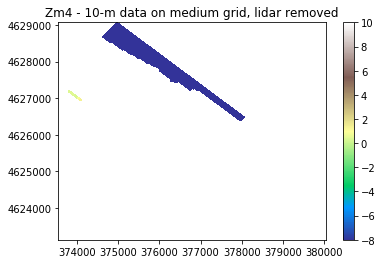

In [39]:
Zm_has_lidar = np.array(~np.isnan(Zm2))
Zm4 = Zm3.copy()
Zm4[Zm_has_lidar]=np.NaN

plt.pcolormesh(Xm,Ym,Zm4,vmin=-8,vmax=10,cmap=plt.cm.terrain)
plt.title('Zm4 - 10-m data on medium grid, lidar removed')
plt.colorbar();

### Remove SfM coverage from lidar version of medium grid: -> `Zm5`

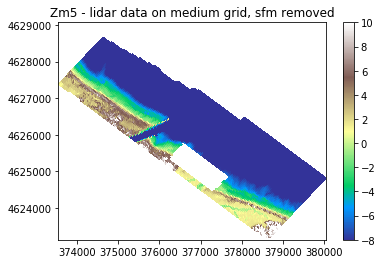

In [40]:
Zm_has_sfm = np.array(~np.isnan(Zm1))
Zm5 = Zm2.copy()
Zm5[Zm_has_sfm]=np.NaN

plt.pcolormesh(Xm,Ym,Zm5,vmin=-8,vmax=10,cmap=plt.cm.terrain)
plt.title('Zm5 - lidar data on medium grid, sfm removed')
plt.colorbar();

### Complete medium grid by combining `Zm1`, `Zm4`, and `Zm5` -> `Zm`

In [41]:
Zmstack = np.stack((Zm1,Zm4,Zm5))
Zm = np.nanmean(Zmstack, 0)

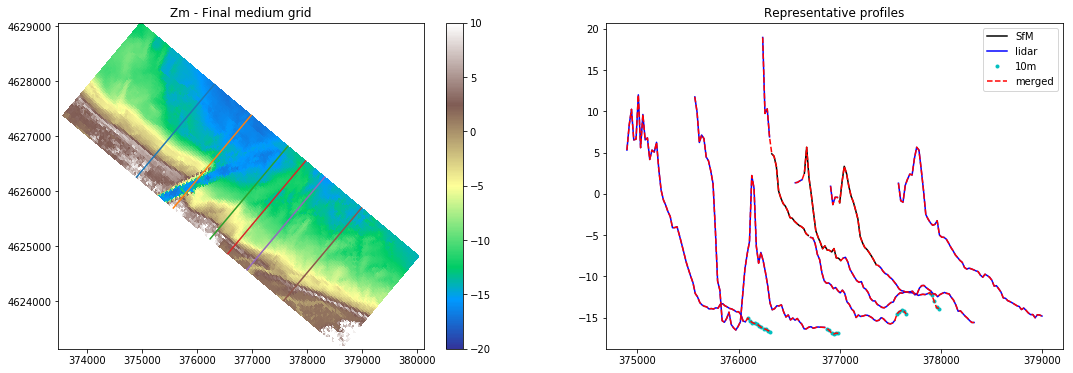

In [42]:
# plot
fig = plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.pcolormesh(Xm,Ym,Zm,vmin=-20,vmax=10,cmap=plt.cm.terrain)
for i in np.array([50,75,100,112,125,150]):
    plt.plot(Xm[:,i],Ym[:,i],'-')

plt.title('Zm - Final medium grid')
plt.colorbar()
plt.axis('equal');
plt.subplot(1,2,2)
for i in np.array([50,75,100,112,125]):
    plt.plot(Xm[:,i],Zm1[:,i],'-k')
    plt.plot(Xm[:,i],Zm5[:,i],'-b')
    plt.plot(Xm[:,i],Zm4[:,i],'.c')
    plt.plot(Xm[:,i],Zm[:,i],'--r')

# one last transect to get the legend
i=150
plt.plot(Xm[:,i],Zm1[:,i],'-k',label='SfM')
plt.plot(Xm[:,i],Zm5[:,i],'-b',label='lidar')
plt.plot(Xm[:,i],Zm4[:,i],'.c',label='10m')
plt.plot(Xm[:,i],Zm[:,i],'--r',label='merged')
plt.title('Representative profiles')
plt.legend();

### Use points in medium grid and 10-m data to interpolate the coarse grid: -> `Zc1` with lots of missing data

xp  (3852, 4874) yp:  (3852, 4874) xpyp:  (12160, 2) zp: : (12160,)
Xc  (68, 192) Yc:  (68, 192) grid points:  (13056, 2)
Wall time: 318 ms


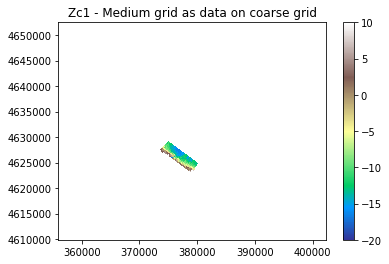

In [43]:
%%time
# Interpolate the medium grid data onto the coarse grid
xpyp = np.array((np.ravel(Xm),np.ravel(Ym))).T
zp = np.ravel(Zm)
print('xp ',np.shape(xp),'yp: ' ,np.shape(yp),'xpyp: ',np.shape(xpyp),'zp: :',np.shape(zp))
print('Xc ',np.shape(Xc),'Yc: ' ,np.shape(Yc),'grid points: ',np.shape(np.array((np.ravel(Xc), np.ravel(Yc))).T))

# interpolate medium grid data on to the coarse grid
Zc1 = interpolate.griddata( xpyp, zp, np.array((np.ravel(Xc), np.ravel(Yc))).T, method='linear', fill_value=np.NaN, rescale=False)
Zc1 = np.reshape(Zc1,np.shape(Xc))

plt.pcolormesh(Xc,Yc,Zc1,vmin=-20,vmax=10,cmap=plt.cm.terrain)
plt.title('Zc1 - Medium grid as data on coarse grid')
plt.colorbar();

### Interpolate the clipped 10-m data on to the coarse grid: -> `Zc2` with no data gaps

In [44]:
%%time
xp, yp = np.meshgrid(x10c,y10c)
xpyp = np.array((np.ravel(xp),np.ravel(yp))).T
zp = np.ravel(z10csf)
print('xp ',np.shape(xp),'yp: ' ,np.shape(yp),'xpyp: ',np.shape(xpyp),'zp: :',np.shape(zp))
print('Xc ',np.shape(Xc),'Yc: ' ,np.shape(Yc),'grid points: ',np.shape(np.array((np.ravel(Xc), np.ravel(Yc))).T))

Zc2 = interpolate.griddata( xpyp, zp, np.array((np.ravel(Xc), np.ravel(Yc))).T, method='nearest', fill_value=np.NaN, rescale=False)
Zc2 = np.reshape(Zc2,np.shape(Xc))

xp  (3852, 4874) yp:  (3852, 4874) xpyp:  (18774648, 2) zp: : (18774648,)
Xc  (68, 192) Yc:  (68, 192) grid points:  (13056, 2)
Wall time: 3min 32s


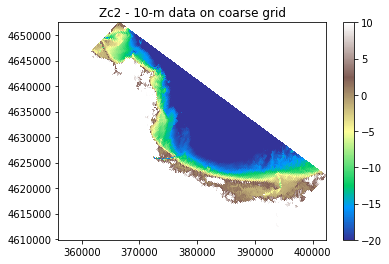

In [45]:
plt.pcolormesh(Xc,Yc,Zc2,vmin=-20,vmax=10,cmap=plt.cm.terrain)
plt.title('Zc2 - 10-m data on coarse grid')
plt.colorbar();

### Remove medium grid coverage from 10-m grid version of coarse grid: -> `Zc3`

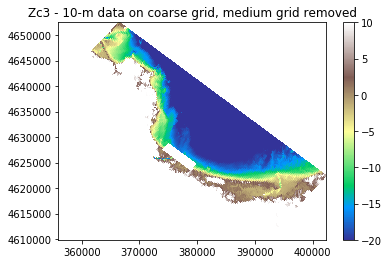

In [46]:
Zc_has_med = np.array(~np.isnan(Zc1))
Zc3 = Zc2.copy()
Zc3[Zc_has_med]=np.NaN

plt.pcolormesh(Xc,Yc,Zc3,vmin=-20,vmax=10,cmap=plt.cm.terrain)
plt.title('Zc3 - 10-m data on coarse grid, medium grid removed')
plt.colorbar();

### Complete coarse grid by combining `Zc1` + `Zc2` -> `Zc`

In [47]:
Zcstack = np.stack((Zc1,Zc3))
Zc = np.nanmean(Zcstack, 0)

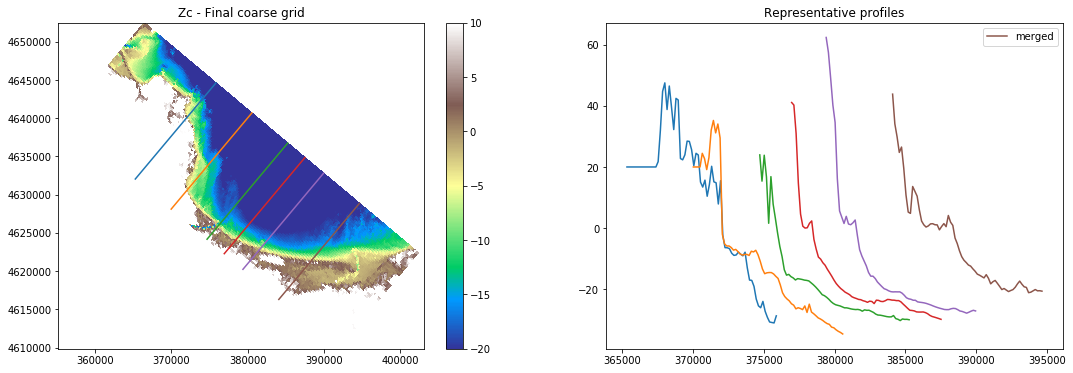

In [48]:
# plot
fig = plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.pcolormesh(Xc,Yc,Zc,vmin=-20,vmax=10,cmap=plt.cm.terrain)
for i in np.array([50,75,100,112,125,150]):
    plt.plot(Xc[:,i],Yc[:,i],'-')

plt.title('Zc - Final coarse grid')
plt.colorbar()
plt.axis('equal');
plt.subplot(1,2,2)
for i in np.array([50,75,100,112,125]):
    plt.plot(Xc[:,i],Zc[:,i],'-')

# one last transect to get the legend
i=150
plt.plot(Xc[:,i],Zc[:,i],'-',label='merged')
plt.title('Representative profiles')
plt.legend();

### Calculate lat/lon coordinates for all three grids 

In [49]:
from pyproj import Proj, transform

outProj = Proj(init='epsg:4326') #WGS84
inProj = Proj(init='epsg:26919') #NAD83 UTM Zone 19N

# Random coordinates with VDatum conversion to check
inx_check=374842.83098
iny_check=4624229.06884

outlon_check=-70.505576
outlat_check= 41.760044

outlon,outlat=transform(inProj,outProj,inx_check,iny_check)

print("Converted Lon / Lat   :  ",outlon,outlat)
print("Reference             :  ",outlon_check, outlat_check)
print("latitude difference = ", (outlat-outlat_check)*111111," meters.")
print("This discrepency is probably due to EPSG:4326 != the CRS used in VDATUM")

outlon, outlat = transform(inProj, outProj, np.ravel(Xf), np.ravel(Yf) )
Latf = np.reshape(outlat, np.shape(Yf))
Lonf = np.reshape(outlon, np.shape(Xf))

outlon, outlat = transform(inProj, outProj, np.ravel(Xm), np.ravel(Ym) )
Latm = np.reshape(outlat, np.shape(Ym))
Lonm = np.reshape(outlon, np.shape(Xm))

outlon, outlat = transform(inProj, outProj, np.ravel(Xc), np.ravel(Yc) )
Latc = np.reshape(outlat, np.shape(Yc))
Lonc = np.reshape(outlon, np.shape(Xc))

Converted Lon / Lat   :   -70.5055751610997 41.76003504123531
Reference             :   -70.505576 41.760044
latitude difference =  -0.9954173032834817  meters.
This discrepency is probably due to EPSG:4326 != the CRS used in VDATUM


### Write grids in as `.mat` files

In [50]:

scipy.io.savemat(ddir+'FG2.mat', mdict={'Latf':Latf, 'Lonf':Lonf, 'Xf':Xf,'Yf':Yf,'Zf': Zf})
scipy.io.savemat(ddir+'MG2.mat', mdict={'Latm':Latm, 'Lonm':Lonm, 'Xm':Xm,'Ym':Ym,'Zm': Zm})
scipy.io.savemat(ddir+'CG2.mat', mdict={'Latc':Latc, 'Lonc':Lonc, 'Xc':Xc,'Yc':Yc,'Zc': Zc})